In [1]:
import yaml
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scatseisnet import ScatteringNetwork
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
plt.style.use('ggplot')

In [2]:
file_path = "/Users/bubble/Project/ev0000364000.h5"
# Open the file
f = h5py.File(file_path, 'r')
# List all the attributes for the file
list(f.attrs.keys())

['ele', 'lat', 'lon', 'mag', 'time']

In [3]:
f.attrs['time']

'2014-07-11T19:22:00.440000Z'

In [4]:
# Shape of the data for a station
dset = f['IWEH']
dset.shape

(3, 270000000)

In [ ]:
# Extract a portion of the data from numerous stations

# List of stations to consider
stations_list = ['IWEH', 'KI2H', 'MKJH', 'NMEH']

# Start and end index values for the portion of data to extract
# 24*3600*100 is 24 hours of data at 100 Hzone day of data.
# this example outputs firt hour of second day:
start = 726*3600*100
end = 750*3600*100

# Number of channels
num_channels = 3

# Allocate the space to save the extracted data
data = np.empty((len(stations_list),num_channels,end-start))

for i in range(len(stations_list)):
    data[i,0:num_channels,:] = f[stations_list[i]][0:num_channels,start:end]
    
print(data.shape)

In [ ]:
fig,ax=plt.subplots(3,figsize=(10,9))
ax[0].plot(data[0,0,:],'k-')
ax[1].plot(data[0,1,:],'k-')
ax[2].plot(data[0,2,3:],'k-')

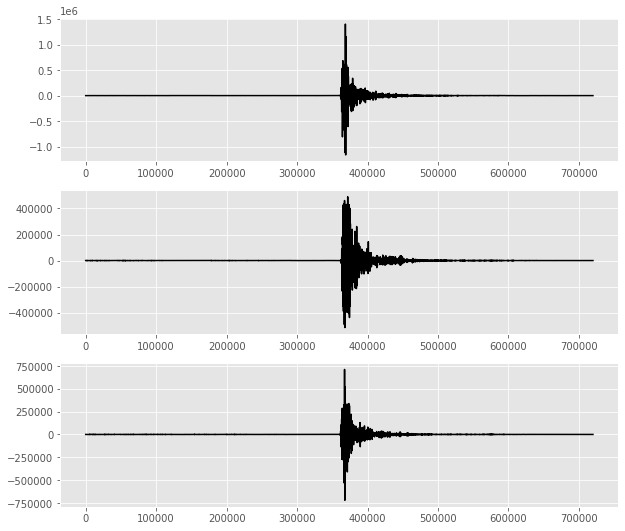

In [5]:
## 地震前2h数据
# Allocate the space to save the extracted data
stations_list = ['IWEH', 'KI2H', 'MKJH', 'NMEH']
num_channels = 3
start = 748*3600*100
end = 750*3600*100
data = np.empty((len(stations_list),num_channels,end-start))

for i in range(len(stations_list)):
    data[i,0:num_channels,:] = f[stations_list[i]][0:num_channels,start:end]

fig,ax=plt.subplots(3,figsize=(10,9))
ax[0].plot(data[0,0,:],'k-')
ax[1].plot(data[0,1,:],'k-')
ax[2].plot(data[0,2,3:],'k-')

## 创建散射网络 

In [26]:
## 参数
segment_duration_seconds = 180.0
sampling_rate_hertz = 100.0
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
bank_keyword_arguments = (
    {"octaves": 4, "resolution": 4, "quality": 1},
    {"octaves": 5, "resolution": 2, "quality": 3},
)

In [27]:
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)

print(network)

ScatteringNetwork(bins=18000, sampling_rate=100.0, len=2)
ComplexMorletBank(bins=18000, octaves=4, resolution=4, quality=1, sampling_rate=100.0, len=16)
ComplexMorletBank(bins=18000, octaves=5, resolution=2, quality=3, sampling_rate=100.0, len=10)


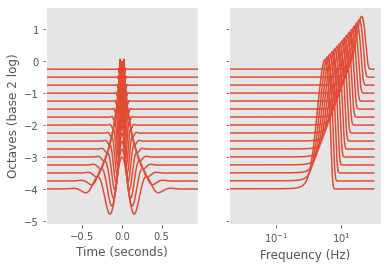

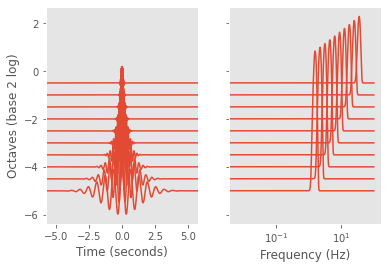

In [28]:
# Loop over network layers
for bank in network.banks:

    # Create axes (left for temporal, right for spectral domain)
    fig, ax = plt.subplots(1, 2, sharey=True)

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets, bank.spectra, bank.ratios
    ):

        # Time domain
        _=ax[0].plot(bank.times, wavelet.real + ratio, "C0")

        # Spectral domain (log of amplitude)
        _=ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()

    # Labels
    _=ax[0].set_ylabel("Octaves (base 2 log)")
    _=ax[0].set_xlabel("Time (seconds)")
    _=ax[0].set_xlim(-width_max, width_max)
    _=ax[0].grid()
    _=ax[1].set_xscale("log")
    _=ax[1].set_xlabel("Frequency (Hz)")
    _=ax[1].grid()


In [9]:
from matplotlib import dates as mdates
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from obspy import Stream, Trace

## 读取地震数据

In [29]:
stations_list = ['IWEH']
start = 726*3600*100
end = 750*3600*100
num_channels = 3

# 初始化一个空的Stream对象
stream = Stream()

# 循环每个测量站，提取相应的数据并添加到Stream对象中
for station in stations_list:
    for i in range(num_channels):
        # 提取数据并转化为Trace对象
        trace_data = f[station][i,start:end]
        trace = Trace(data=np.array(trace_data))
        
        # 为Trace对象添加元数据，例如网络，站点和通道信息
        trace.stats.network = "Hi-Net"
        trace.stats.sampling_rate = 100.0
        trace.stats.station = station
        trace.stats.channel = "channel_" + str(i)
        trace.stats.starttime = UTCDateTime('2014-07-10T19:22:00.440000Z')

        # 将Trace对象添加到Stream中
        stream += trace

In [30]:
stream

3 Trace(s) in Stream:
Hi-Net.IWEH..channel_0 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..channel_1 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..channel_2 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

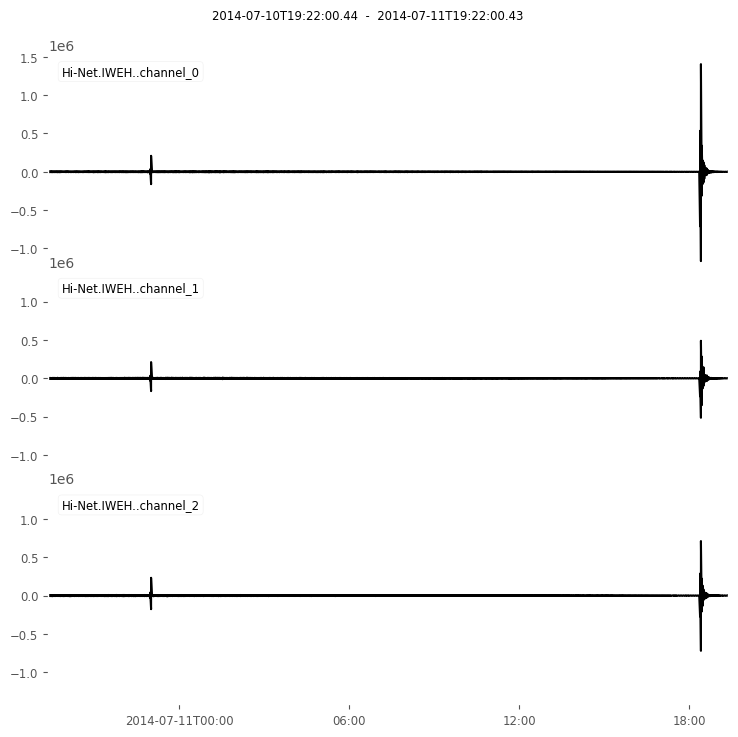

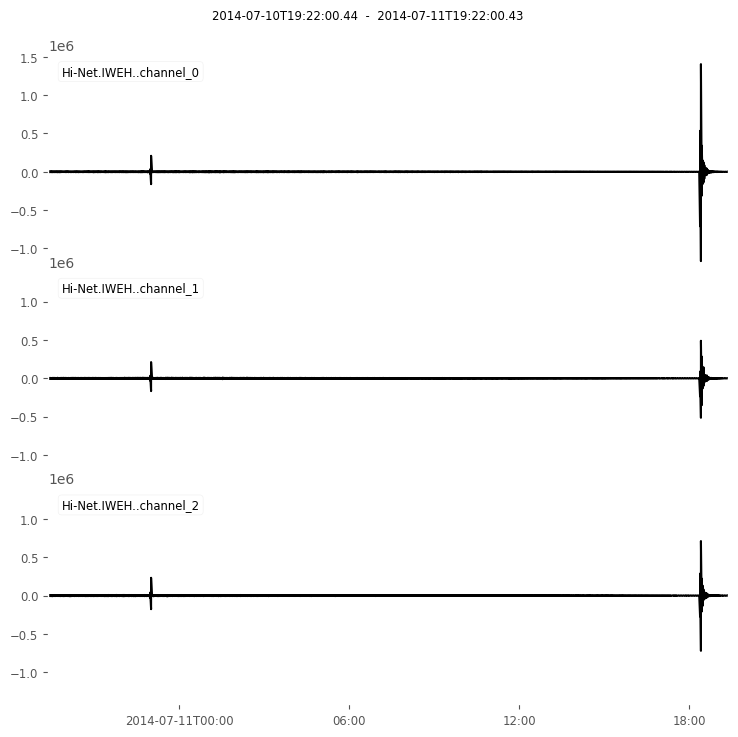

In [31]:
stream.plot()

### 去除趋势、合并潜在的非重叠段. 并在 10 Hz 以上对其进行高通滤波

3 Trace(s) in Stream:
Hi-Net.IWEH..channel_0 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..channel_1 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..channel_2 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.IWEH..channel_0 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..channel_1 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..channel_2 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.IWEH..channel_0 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..channel_1 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..channel_2 | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

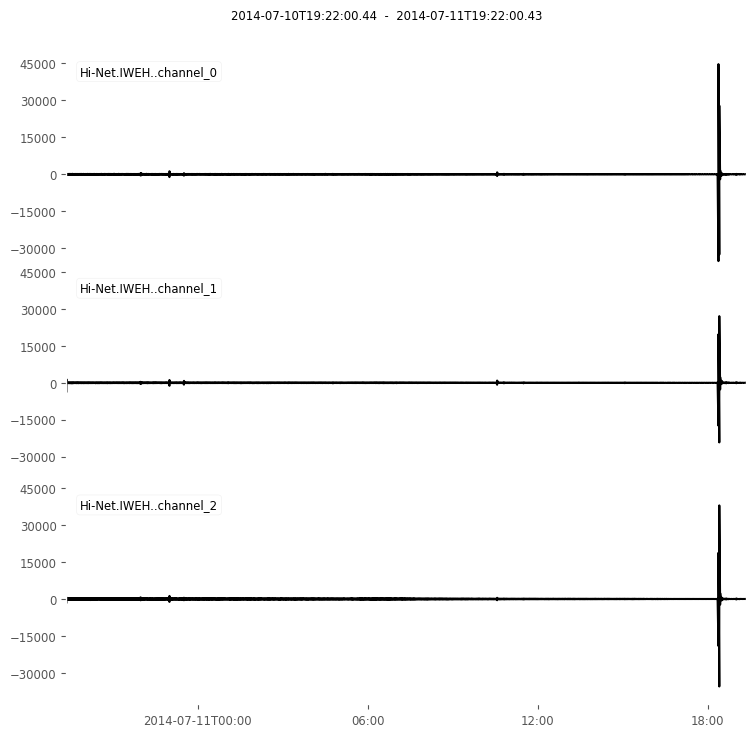

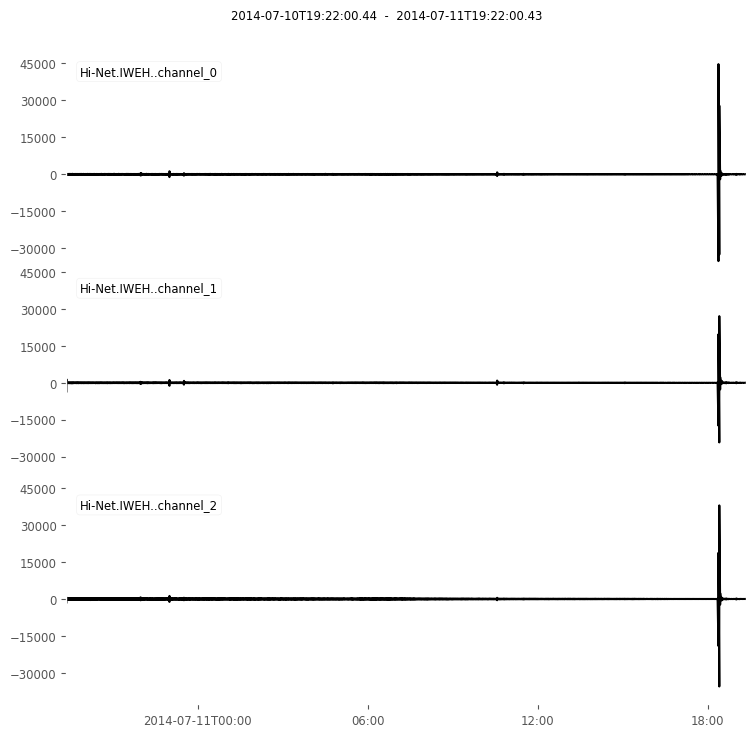

In [32]:
stream.merge(method=1)
stream.detrend("linear")
#stream1=stream.copy()
stream.filter(type="highpass", freq=1)
stream.plot(rasterized=True)

数据分成等长的段

In [25]:
network.sampling_rate

100.0

In [33]:
# Extract segment length (from any layer)
segment_duration = network.bins / network.sampling_rate
overlap = 0.5

# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Collect data and timestamps
for traces in stream.slide(segment_duration, segment_duration * overlap):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

In [37]:
len(segments)
segments[957].shape
segments[958].shape

959

(3, 18000)

(3, 17999)

In [38]:
if segments[-1].shape != (3, 18000):
    padding = np.zeros((3, 18000 - segments[-1].shape[1]))
    segments[-1] = np.concatenate([segments[-1], padding], axis=1)

In [39]:
a=np.array(segments)
a.shape

(959, 3, 18000)

计算散射系数

In [40]:
scattering_coefficients = network.transform(segments, reduce_type=np.max)

观察单个通道的结果

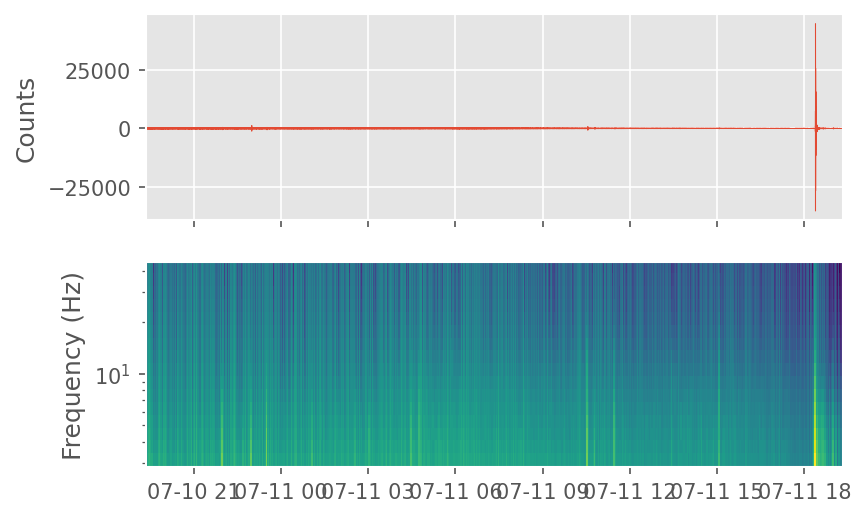

In [41]:
# Extract the first channel
channel_id = 0
trace = stream[channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# Create figure and axes
fig, ax = plt.subplots(2, sharex=True, dpi=150)

# Plot the waveform
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# First-order scattering coefficients
ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)

# Axes labels
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")

# Show
plt.show();

In [42]:
order_1=scattering_coefficients[0]
order_2=scattering_coefficients[1]
times=timestamps

开始聚类

In [43]:
from sklearn.decomposition import FastICA

In [44]:
# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 959 samples of 528 dimensions each.


In [45]:
model = FastICA(n_components=10, whiten="unit-variance", random_state=42)
features = model.fit_transform(scattering_coefficients)

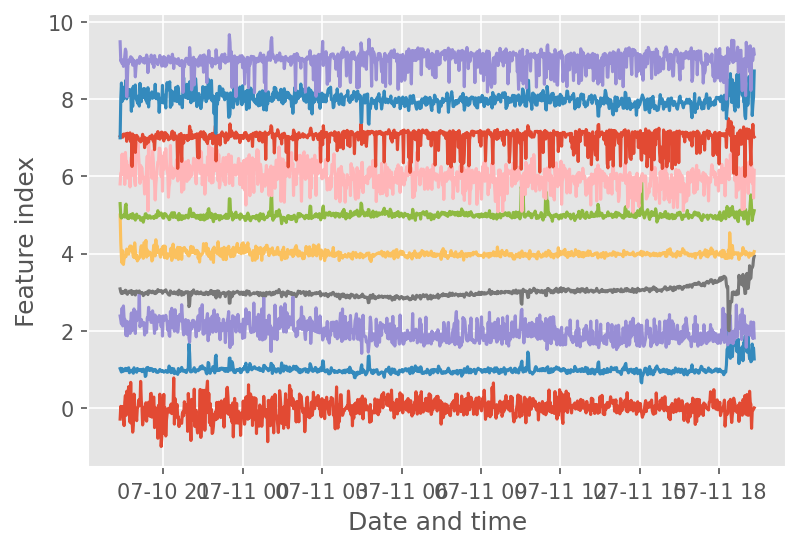

In [46]:
# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=150)
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Date and time")

# Show
plt.show();

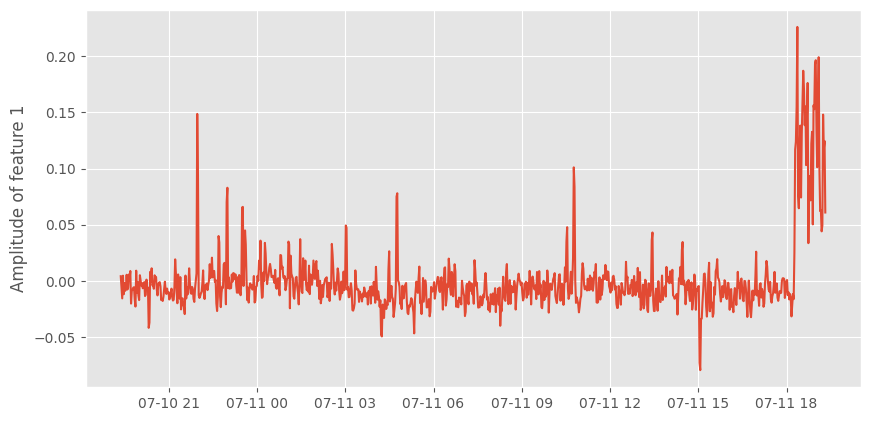

In [47]:
# Pick a feature
feature_id = 1
feature = features[:, feature_id]

# Figure creation
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = plt.axes()

# Plot the weights
ax.plot(times, feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")

# Show
plt.show();

In [50]:
# Etract weights from the dimensionality reduction model
weights = model.components_[feature_id]
vmax = np.abs(weights).max()

# Scattering coefficients shape and frequencies
n_cha = 3
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_2 = network.banks[1].octaves * network.banks[1].resolution
f_1 = network.banks[0].centers
f_2 = network.banks[1].centers

# Extract and reshape weights
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)
order_2 = weights[n_cha * n_order_1 :].reshape(n_cha, n_order_1, n_order_2)

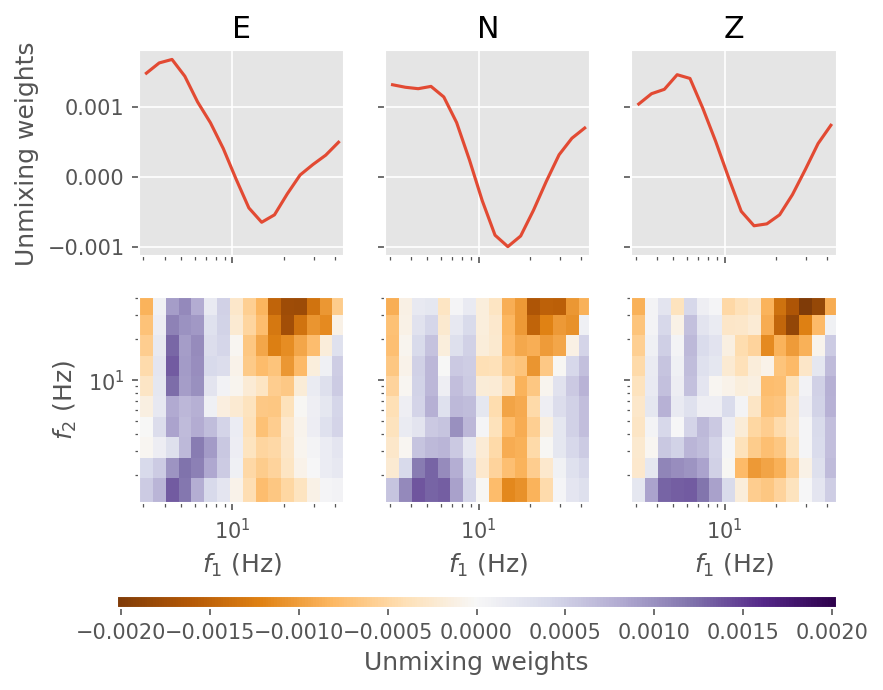

In [51]:
# Show weights
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey="row", dpi=150)
image_kw = dict(vmin=-vmax, vmax=vmax, rasterized=True, cmap="PuOr")
for id, channel in enumerate("ENZ"):

    # Show
    ax[0, id].plot(f_1, order_1[id], label=channel)
    mappable = ax[1, id].pcolormesh(f_1, f_2, order_2[id].T, **image_kw)

    # Labels
    ax[0, id].set_title(channel)
    ax[1, id].set_xlabel("$f_1$ (Hz)")

# Labels
ax[0, 0].set_ylabel("Unmixing weights")
ax[1, 0].set_ylabel("$f_2$ (Hz)")
ax[1, 0].set_xscale("log")
ax[1, 0].set_yscale("log")

# Colorbar
left, bottom, width, height =  0.1, -0.05, 0.8, 0.02  # Customize the position and size of the colorbar here.
cax = fig.add_axes([left, bottom, width, height])
colorbar = fig.colorbar(mappable, cax=cax, orientation="horizontal")
colorbar.set_label("Unmixing weights")

# Show
plt.show();


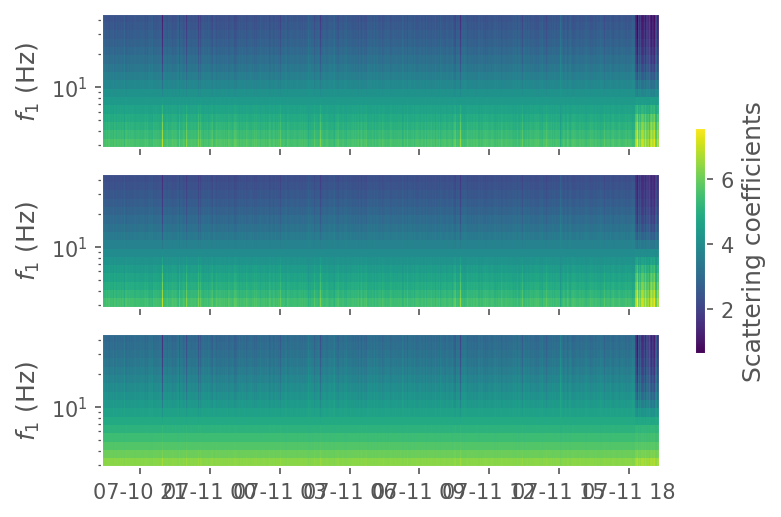

In [52]:
# Filter out latent space
features_filtered = np.zeros(features.shape)
features_filtered[:, feature_id] = feature

# Extract all scattering coefficients
reconstructed = model.inverse_transform(features_filtered)
reconstructed_order_1 = reconstructed[:, : n_cha * n_order_1].reshape(-1, n_cha, n_order_1)
vmin = reconstructed_order_1.min()
vmax = reconstructed_order_1.max()

# Plot
fig, ax = plt.subplots(nrows=3, sharex=True, sharey="row", dpi=150)

# Plot
for id, channel in enumerate("ENZ"):
    data = reconstructed_order_1[:, id, :].squeeze().T
    mappable = ax[id].pcolormesh(times, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)
    ax[id].set_ylabel("$f_1$ (Hz)")
    ax[id].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="vertical", ax=ax, shrink=0.5)
colorbar.set_label("Scattering coefficients")
plt.show();

In [53]:
from scipy import signal
from sklearn.cluster import KMeans

In [54]:
features.shape

(959, 10)

In [55]:
N_CLUSTERS = 10

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, init="k-means++", random_state=4)
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)


KMeans(n_clusters=10, random_state=4)

每个聚类的信号随时间变化情况

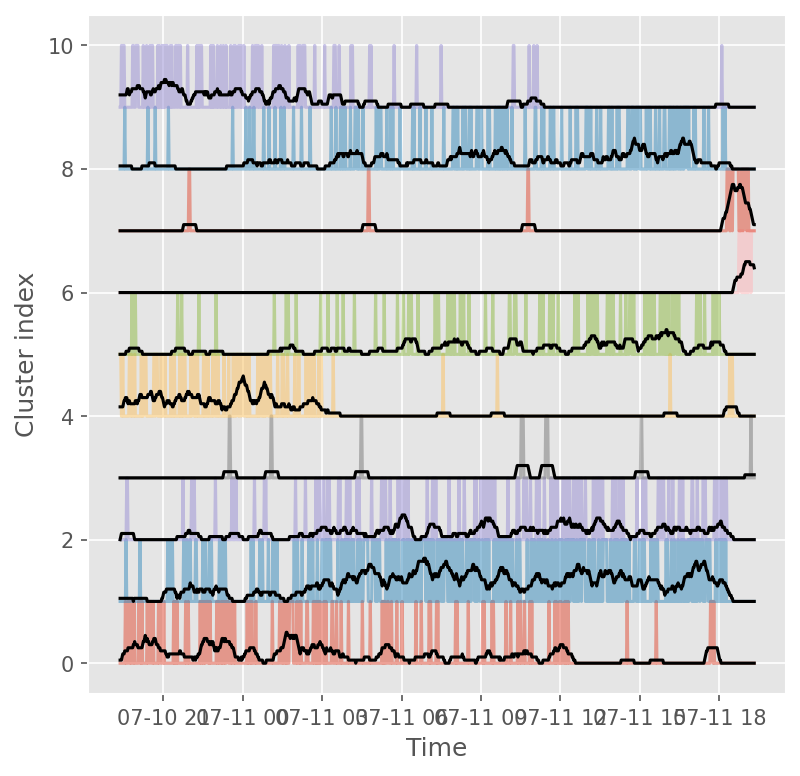

In [56]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show();

类比与特征的关系

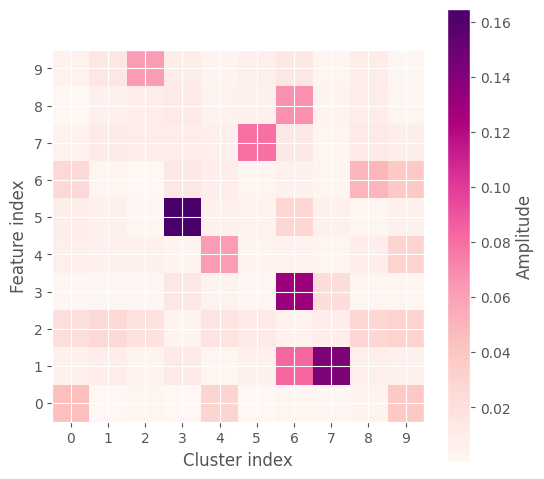

In [57]:
centroids = np.abs(model.cluster_centers_)

# Plot the centroids
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show();

In [58]:
N_WAVEFORMS = 5

waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    
    # Convert boolean array to integer indices
    indices = np.where(predictions == cluster)[0]
    closest_indices = indices[distance.argsort()[:5]]
    closest = [times[i] for i in closest_indices]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy() 
        traces.append(trace)
    waveforms.append(traces)


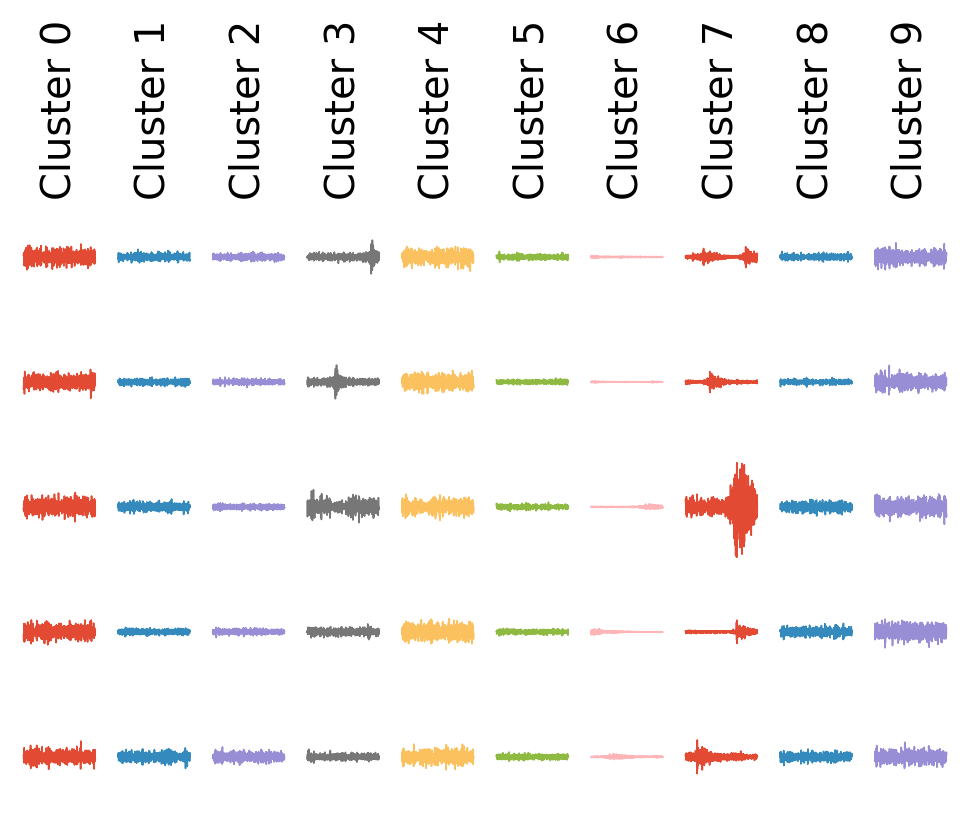

In [59]:
# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=200)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show();